In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import math
import string
from collections import Counter
import re
import random
import numpy as np
import json
from tqdm import tqdm
import gc

from collections import defaultdict
from typing import List, Tuple, Dict

In [2]:
torch.cuda.empty_cache()
gc.collect()

1124

In [3]:
# Special tokens
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


### Preprocessing

In [6]:
def preprocess_sentence(sentence: str) -> str:
    """
    Preprocess a sentence: remove punctuation, non-alphanumeric characters, and extra spaces.
    """
    # Remove punctuation and non-alphanumeric characters
    sentence = re.sub(r"[^a-zA-Z0-9]+", " ", sentence)
    # Strip extra spaces
    sentence = re.sub(r"\s+", " ", sentence).strip()
    # Convert to lower case
    sentence = sentence.lower()
    
    return sentence

def load_data(file_path: str) -> List[str]:
    """
    Load data from a file, one sentence per line.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file.readlines()]

def add_special_tokens(sentences: List[str]) -> List[str]:
    """
    Prepend <sos> and append <eos> token to each sentence.
    """
    return [f"{SOS_TOKEN} {sentence} {EOS_TOKEN}" for sentence in sentences]

def pad_sentences(sentences: List[str], max_len: int) -> List[str]:
    """
    Pad sentences to the maximum length using the <pad> token.
    """
    return [sentence + f" {PAD_TOKEN}" * (max_len - len(sentence.split())) for sentence in sentences]

def build_vocab(sentences: List[str]) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Build word2idx and idx2word mappings from sentences.
    """
    word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1, SOS_TOKEN: 2, EOS_TOKEN: 3}
    idx2word = {0: PAD_TOKEN, 1: UNK_TOKEN, 2: SOS_TOKEN, 3: EOS_TOKEN}
    word_freq = defaultdict(int)

    idx = 4
    for sentence in tqdm(sentences, desc="Building Vocabulary"):
        for word in sentence.split():
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

In [7]:
def preprocess_data(english_sentences: List[str], french_sentences: List[str]) -> Tuple[List[str], List[str], Dict[str, int], Dict[int, str], Dict[str, int], Dict[int, str]]:
    """
    Full preprocessing pipeline: clean, add tokens, pad, and build vocab.
    """
    # Preprocess sentences
    english_sentences = [preprocess_sentence(s) for s in tqdm(english_sentences, desc="Preprocessing English Sentences")]
    french_sentences = [preprocess_sentence(s) for s in tqdm(french_sentences, desc="Preprocessing French Sentences")]

    # Add <sos> and <eos> tokens
    english_sentences = add_special_tokens(english_sentences)
    french_sentences = add_special_tokens(french_sentences)
    
    # Store original sentence lengths (before padding)
    english_lengths = [len(s.split()) for s in english_sentences]
    french_lengths = [len(s.split()) for s in french_sentences]

    # Pad sentences independently for English and French
    max_len_en = max(english_lengths)  # Max length for English sentences
    max_len_fr = max(french_lengths)   # Max length for French sentences
    
    print(max_len_en)
    print(max_len_fr)

    # Pad sentences
    english_sentences = pad_sentences(english_sentences, max_len_en)
    french_sentences = pad_sentences(french_sentences, max_len_fr)

    # Build vocabularies for English and French
    word2idx_en, idx2word_en = build_vocab(english_sentences)
    word2idx_fr, idx2word_fr = build_vocab(french_sentences)

    return (english_sentences, french_sentences, word2idx_en, idx2word_en, word2idx_fr, idx2word_fr, english_lengths, french_lengths)

In [8]:
train_en = load_data("/kaggle/input/translation-task/ted-talks-corpus/train.en")

train_fr = load_data("/kaggle/input/translation-task/ted-talks-corpus/train.fr")

In [9]:
(train_en, train_fr, word2idx_en, idx2word_en,
 word2idx_fr, idx2word_fr, english_lengths, french_lengths) = preprocess_data(train_en, train_fr)

Preprocessing French Sentences: 100%|██████████| 30000/30000 [00:00<00:00, 44313.27it/s]


507
546


Building Vocabulary: 100%|██████████| 30000/30000 [00:02<00:00, 13696.17it/s]


### Dataloader for the task

In [10]:
class TranslationDataset(Dataset):
    def __init__(self, english_sentences, french_sentences, english_lengths, french_lengths, word2idx_en, word2idx_fr):
        self.english_sentences = english_sentences
        self.french_sentences = french_sentences
        self.english_lengths = english_lengths
        self.french_lengths = french_lengths
        self.word2idx_en = word2idx_en
        self.word2idx_fr = word2idx_fr

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        # Tokenize sentences (split into words)
        en_sentence = self.english_sentences[idx].split()
        fr_sentence = self.french_sentences[idx].split()

        # Convert words to indices
        en_indices = [self.word2idx_en.get(word, self.word2idx_en[UNK_TOKEN]) for word in en_sentence]
        fr_indices = [self.word2idx_fr.get(word, self.word2idx_fr[UNK_TOKEN]) for word in fr_sentence]

        # Convert to tensors
        en_tensor = torch.tensor(en_indices, dtype=torch.long)
        fr_tensor = torch.tensor(fr_indices, dtype=torch.long)

        # Get lengths
        en_length = self.english_lengths[idx]
        fr_length = self.french_lengths[idx]

        return en_tensor, fr_tensor, en_length, fr_length

In [11]:
train_dataset = TranslationDataset(train_en, train_fr, english_lengths, french_lengths, word2idx_en, word2idx_fr)

# Parameters
batch_size = 16  # Adjust batch size as needed
shuffle = True   # Shuffle data for training

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

### Positional Encoding Implementation

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        pe = torch.zeros(seq_len, d_model)

        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)

        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))

        pe = pe.unsqueeze(0) # (1, seq_len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False).to(device) # (batch, seq_len, d_model)
        return x

### Multi-head attention implementation

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.depth = d_model // num_heads

        # Linear layers for queries, keys, and values
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Output linear layer
        self.fc_out = nn.Linear(d_model, d_model)

    def split_heads(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1, self.num_heads, self.depth)
        return x.transpose(1, 2)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        batch_size = query.size(0)

        # Linear transformations
        q = self.W_q(query)
        k = self.W_k(key)
        v = self.W_v(value)

        # Split into heads
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        scaled_attention_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.depth)

        if mask is not None:
            mask = mask.unsqueeze(1)
            # scaled_attention_logits += (mask * -1e9)
            scaled_attention_logits = scaled_attention_logits.masked_fill(mask, -1e9)

        attention_weights = torch.softmax(scaled_attention_logits, dim=-1)

        output = torch.matmul(attention_weights, v)
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, -1, self.d_model)

        return self.fc_out(output)

### FFN and Encoder Layer implementation

In [14]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(torch.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout_rate: float):
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        
        # Layer normalization and dropout
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # Multi-head attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.layernorm1(x + self.dropout1(attn_output))  # Residual connection and layer norm

        # Feedforward network
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output))  # Residual connection and layer norm

        return x

### Aggregated Encoder architecture

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, d_model: int, num_heads: int, num_layers: int, d_ff: int, dropout_rate: float, pad_idx: int):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)

        self.pad_idx = pad_idx  # Padding index for mask creation
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout_rate)

        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout_rate) for _ in range(num_layers)])

    def forward(self, x: torch.Tensor, mask) -> torch.Tensor:

        x = self.embedding(x) * math.sqrt(self.d_model)

        pos_enc = PositionalEncoding(self.d_model, x.size(1))
        x = pos_enc(x)

        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)

        return x

### Complete Decoder layer

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout_rate: float):
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)

        # Layer normalization and dropout
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, look_ahead_mask: torch.Tensor, padding_mask: torch.Tensor) -> torch.Tensor:
        # Masked Multi-head Self-Attention
        self_attn_output = self.self_attn(query=x, key=x, value=x, mask=look_ahead_mask)
        x = self.layernorm1(x + self.dropout1(self_attn_output))

        # Cross Multi-head Attention
        cross_attn_output = self.cross_attn(query=x, key=encoder_output, value=encoder_output, mask=padding_mask)
        x = self.layernorm2(x + self.dropout2(cross_attn_output))

        # Feedforward Network
        ffn_output = self.ffn(x)
        x = self.layernorm3(x + self.dropout3(ffn_output))

        return x

### Aggregate Decoder

In [17]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size: int, d_model: int, num_heads: int, num_layers: int, d_ff: int, dropout_rate: float, pad_idx: int):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(target_vocab_size, d_model)
#         self.positional_encoding = PositionalEncoding(d_model)
        self.pad_idx = pad_idx
        self.d_model = d_model
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout_rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, enc_output: torch.Tensor, look_ahead_mask: torch.Tensor, padding_mask: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        
        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        pos_enc = PositionalEncoding(self.d_model, x.size(1))
        x = pos_enc(x)
        x = self.dropout(x)
        
        # Pass through the decoder layers
        for layer in self.layers:
            x = layer(x, enc_output, look_ahead_mask, padding_mask)
        
        return x  # Shape: (batch_size, tgt_seq_len, d_model)

In [18]:
def create_padding_mask(seq_q: torch.Tensor, seq_k: torch.Tensor, pad_idx: int) -> torch.Tensor:
    """
    Create a padding mask for the attention mechanism.

    Args:
        seq_q (torch.Tensor): Query sequence tensor of shape (batch_size, seq_len_q).
        seq_k (torch.Tensor): Key sequence tensor of shape (batch_size, seq_len_k).
        pad_idx (int): Padding token index.

    Returns:
        torch.Tensor: Padding mask of shape (batch_size, seq_len_q, seq_len_k), where positions
                      with padding tokens in seq_k are True.
    """
    mask = (seq_k == pad_idx).unsqueeze(1)  # Shape: (batch_size, 1, seq_len_k)
    mask = mask.expand(-1, seq_q.size(1), -1)  # Shape: (batch_size, seq_len_q, seq_len_k)
    return mask.to(device)

def create_look_ahead_mask(seq_len: int) -> torch.Tensor:
    """
    Create a look-ahead mask to mask future tokens in the decoder's self-attention.

    Args:
        seq_len (int): Sequence length.

    Returns:
        torch.Tensor: Look-ahead mask of shape (seq_len, seq_len), where positions
                      in the upper triangle (future positions) are True.
    """
    mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()
    return mask

def create_combined_mask(tgt_input: torch.Tensor, pad_idx: int) -> torch.Tensor:
    """
    Create a combined mask for the decoder's self-attention.

    Args:
        tgt_input (torch.Tensor): Target input tensor of shape (batch_size, tgt_len).
        pad_idx (int): Padding token index.

    Returns:
        torch.Tensor: Combined mask of shape (batch_size, tgt_len, tgt_len).
    """
    tgt_padding_mask = create_padding_mask(tgt_input, tgt_input, pad_idx)  # Shape: (batch_size, tgt_len, tgt_len)
    look_ahead_mask = create_look_ahead_mask(tgt_input.size(1))            # Shape: (tgt_len, tgt_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0).expand(tgt_input.size(0), -1, -1)
    combined_mask = tgt_padding_mask | look_ahead_mask
    return combined_mask

### Complete Transformer

In [19]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, src_pad_idx: int, tgt_pad_idx: int,
                 num_layers: int = 6, d_model: int = 512, num_heads: int = 8, d_ff: int = 2048, dropout_rate: float = 0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, num_layers, d_ff, dropout_rate, src_pad_idx)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, num_layers, d_ff, dropout_rate, tgt_pad_idx)
        self.final_layer = nn.Linear(d_model, tgt_vocab_size)
    
    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Transformer model.

        Args:
            src (torch.Tensor): Source input tensor of shape (batch_size, src_len).
            tgt (torch.Tensor): Target input tensor of shape (batch_size, tgt_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, tgt_len, tgt_vocab_size).
        """
        # Create masks
        src_mask = create_padding_mask(src, src, src_pad_idx)  # (batch_size, 1, src_len, src_len)
        enc_output = self.encoder(src, src_mask)          # (batch_size, src_len, d_model)

        tgt_input = tgt[:, :-1]   # Exclude the last token for input

        # Create masks for decoder
        self_attn_mask = create_combined_mask(tgt_input, tgt_pad_idx)  # (batch_size, tgt_len, tgt_len)
        cross_attn_mask = create_padding_mask(tgt_input, src, src_pad_idx)  # (batch_size, tgt_len, src_len)

        dec_output = self.decoder(tgt_input, enc_output, self_attn_mask, cross_attn_mask)  # (batch_size, tgt_len, d_model)

        # Final linear layer
        output = self.final_layer(dec_output)  # (batch_size, tgt_len, tgt_vocab_size)

        return output

### Training method

In [20]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4

src_vocab_size = len(word2idx_en)
tgt_vocab_size = len(word2idx_fr)
src_pad_idx = word2idx_en[PAD_TOKEN]
tgt_pad_idx = word2idx_fr[PAD_TOKEN]

d_model = 512
num_layers = 6
num_heads = 8
d_ff = 1024
dropout_rate = 0.1

assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

In [21]:
# # Initialize model
model = Transformer(src_vocab_size, tgt_vocab_size, src_pad_idx, tgt_pad_idx, num_layers, d_model, num_heads, d_ff, dropout_rate)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tgt_pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
validation_losses = []
train_losses = []

In [22]:
torch.cuda.empty_cache()
gc.collect()

0

In [26]:
def preprocess_val_data(test_sentences: List[str], word2idx: Dict[str, int], max_len):
    """
    Preprocess val data by adding <sos> and <eos> tokens and padding.
    
    Args:
        test_en_sentences (List[str]): List of raw English test sentences.
        word2idx_en (Dict[str, int]): Source language vocabulary mapping (word2idx).
        max_len_en (int): Maximum sequence length for source language (same as used during training).
    
    Returns:
        List[torch.Tensor]: List of tokenized, padded tensors for test data.
    """
    # Preprocess sentences: lowercase, remove punctuation, etc.
    test_sentences = [preprocess_sentence(s) for s in test_sentences]

    # Add <sos> and <eos> tokens
    test_sentences = add_special_tokens(test_sentences)
    
    # Store original sentence lengths (before padding)
    lengths = [len(s.split()) for s in test_sentences]

    max_len_see = max(lengths) 
    print(f"Max lens see: {max_len_see}")
    
    # Pad sentences to the same max length 
    test_sentences = pad_sentences(test_sentences, max_len_see)

    # Convert sentences to indices using word2idx mapping
    test_indices = []
    for sentence in test_sentences:
        indices = [word2idx.get(word, word2idx[UNK_TOKEN]) for word in sentence.split()]
        test_indices.append(torch.tensor(indices, dtype=torch.long))

    return test_indices, max_len_see

max_len_en = 507
max_len_fr = 546

val_en = load_data("/kaggle/input/translation-task/ted-talks-corpus/dev.en")  # Load raw test data
val_en_tensors, max_len_en_val = preprocess_val_data(val_en, word2idx_en, max_len_en)  # Preprocess test data
print("Loaded test english tensors successfully!")

val_fr = load_data("/kaggle/input/translation-task/ted-talks-corpus/dev.fr")  # Load raw test data
val_fr_tensors, max_len_fr_val = preprocess_val_data(val_fr, word2idx_fr, max_len_fr)  # Preprocess test data
print("Loaded test french tensors successfully!")

class TranslationValDataset(Dataset):
    def __init__(self, src_tensors, tgt_tensors):
        """
        Dataset for loading val data.

        Args:
            src_tensors (List[torch.Tensor]): List of preprocessed source (English) tensors.
            tgt_tensors (List[torch.Tensor]): List of preprocessed target (French) tensors.
        """
        self.src_tensors = src_tensors
        self.tgt_tensors = tgt_tensors

    def __len__(self):
        return len(self.src_tensors)

    def __getitem__(self, idx):
        return self.src_tensors[idx], self.tgt_tensors[idx]

# Create the test dataset
val_dataset = TranslationValDataset(val_en_tensors, val_fr_tensors)

# Create the DataLoader
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Adjust batch_size as needed

Max lens see: 159
Loaded test english tensors successfully!
Max lens see: 179
Loaded test french tensors successfully!


In [27]:
def evaluate_model(model, test_dataloader, criterion, device):
    """
    Evaluate the Transformer model on the test dataset.

    Args:
        model (nn.Module): The trained Transformer model.
        test_dataloader (DataLoader): DataLoader for the test dataset.
        criterion (nn.CrossEntropyLoss): Loss function.
        device (torch.device): Device to run the evaluation on.

    Returns:
        float: The average loss over the test dataset.
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Evaluating...")
    
    with torch.no_grad():
        for batch_idx, batch in progress_bar:
            src_batch, tgt_batch = batch
            # Move data to device
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # Forward pass
            outputs = model(src_batch, tgt_batch)

            # Prepare target output (shifted by 1 to exclude <sos>)
            tgt_output = tgt_batch[:, 1:].contiguous().view(-1)  # (batch_size * (tgt_len - 1))

            # Reshape model outputs for loss computation
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * (tgt_len - 1), tgt_vocab_size)

            # Compute loss
            loss = criterion(outputs, tgt_output)

            # Accumulate total loss
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            num_batches += 1
            

    # Calculate average loss
    avg_loss = total_loss / num_batches
    return avg_loss

## training loop

In [ ]:
torch.cuda.empty_cache()
gc.collect()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, batch in progress_bar:
        src_batch, tgt_batch, src_lengths, tgt_lengths = batch

        # Move tensors to device
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        # Forward pass
        
        outputs = model(src_batch, tgt_batch)
        outputs = outputs.view(-1, tgt_vocab_size)
        
        tgt_output = tgt_batch[:, 1:]
        tgt_output = tgt_output.contiguous().view(-1)

        loss = criterion(outputs, tgt_output)
        
        torch.cuda.empty_cache()
        gc.collect()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    average_loss = epoch_loss / len(train_dataloader)
    
    train_losses.append(average_loss)
    
    val_loss = evaluate_model(model, val_dataloader, criterion, device)
    
    validation_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}")

In [ ]:
import torch
import os

def save_checkpoint(state, filename="transformer_checkpoint.pth.tar"):
    """
    Save the training model.

    Args:
        state (dict): Contains model's state_dict, optimizer's state_dict, epoch, etc.
        filename (str): Path to save the checkpoint.
    """
    torch.save(state, filename)

# After training is done
save_checkpoint({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'src_vocab': word2idx_en,
    'tgt_vocab': word2idx_fr,
    'idx2word_en': idx2word_en,
    'idx2word_fr': idx2word_fr,
    'd_model': d_model,
    'num_layers': num_layers,
    'num_heads': num_heads,
    'd_ff': d_ff,
    'dropout_rate': dropout_rate,
}, filename="transformer_checkpoint.pth.tar")

In [ ]:
def save_model(model, filename="model.pth"):
    """
    Save the model's state dictionary to a file.

    Args:
        model (nn.Module): The model to save.
        filename (str): The path where the model will be saved.
    """
    torch.save(model.state_dict(), filename)
    
save_model(model, "scratch_transformer_model.pth")

In [ ]:
def save_entire_model(model, filename="model.pth"):
    """
    Save the entire model object to a file.

    Args:
        model (nn.Module): The model to save.
        filename (str): The file path where the model will be saved.
    """
    torch.save(model, filename)
    
save_entire_model(model, "entire_transformer_model.pth")

In [ ]:
print(len(word2idx_en))

---

### Hyperparameter Tuning

In [28]:
hyperparameter_configs = [
    {
        'num_layers': 4,
        'num_heads': 4,
        'd_model': 128,
        'd_ff': 256,
        'dropout_rate': 0.2
    },
    {
        'num_layers': 4,
        'num_heads': 4,
        'd_model': 256,
        'd_ff': 512,
        'dropout_rate': 0.1
    },
    {
        'num_layers': 6,
        'num_heads': 8,
        'd_model': 512,
        'd_ff': 1024,
        'dropout_rate': 0.1
    }
]

num_epochs = 7
learning_rate = 1e-4

In [29]:
!pip install nltk rouge-score
import torch
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def translate_sentence(model, src_seq, word2idx_fr, idx2word_fr, max_len=50, device='cpu'):
    """
    Generate a translation for a single source sentence.
    
    Args:
        model (nn.Module): The trained Transformer model.
        src_seq (torch.Tensor): The source sequence tensor.
        word2idx_fr (Dict[str, int]): Target language vocabulary mapping.
        idx2word_fr (Dict[int, str]): Target language reverse vocabulary mapping.
        max_len (int): Maximum length of the generated translation.
        device (torch.device): The device to run the model on.
    
    Returns:
        List[str]: The generated translation as a list of tokens.
    """
    model.eval()
    src_seq = src_seq.to(device)
    src_mask = create_padding_mask(src_seq, src_seq, word2idx_fr[PAD_TOKEN])

    with torch.no_grad():
        # Encode the source sentence
        enc_output = model.encoder(src_seq, src_mask)

        # Initialize the target sentence with <sos> token
        tgt_indices = [word2idx_fr[SOS_TOKEN]]

        for _ in range(max_len):
            tgt_input = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            
            tgt_mask = create_combined_mask(tgt_input, word2idx_fr[PAD_TOKEN])
            
            cross_attn_mask = create_padding_mask(tgt_input, src_seq, src_pad_idx)            
            
            # Decode step-by-step
            dec_output = model.decoder(tgt_input, enc_output, tgt_mask, cross_attn_mask)
            logits = model.final_layer(dec_output)
            
            # Get the predicted token (take the token with the highest probability)
            next_token_logits = logits[:, -1, :]  # Last token
            next_token = torch.argmax(next_token_logits, dim=-1).item()
            
            if next_token == word2idx_fr[EOS_TOKEN]:
                break

            tgt_indices.append(next_token)

    # Convert token indices to words
    translation_tokens = [idx2word_fr[idx] for idx in tgt_indices[1:]]  # Skip the <sos> token
    return translation_tokens

from nltk.translate.bleu_score import SmoothingFunction

def compute_bleu(reference, translation):
    """
    Compute BLEU score for a single reference and translation.
    
    Args:
        reference (List[str]): The reference sentence as a list of tokens.
        translation (List[str]): The translated sentence as a list of tokens.
    
    Returns:
        float: BLEU score.
    """
    smoothing_function = SmoothingFunction().method7
    if len(translation) == 1:
        # If translation is a single word, compute BLEU-1
        weights = (1.0,)
    else:
        # Use default weights or adjust as needed
        weights = (0.25, 0.25, 0.25, 0.25)
    return sentence_bleu(
        [reference], 
        translation, 
        smoothing_function=smoothing_function, 
        weights=weights
    )

def compute_rouge(reference, translation):
    """
    Compute ROUGE score for a single reference and translation.
    
    Args:
        reference (List[str]): The reference sentence as a list of tokens.
        translation (List[str]): The translated sentence as a list of tokens.
    
    Returns:
        Dict: ROUGE-L score.
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference), ' '.join(translation))
    return scores['rougeL'].fmeasure

In [30]:
def evaluate_model_metrics(model, dataloader, word2idx_src, word2idx_tgt, idx2word_tgt, device):
    model.eval()
    src_pad_idx = word2idx_src[PAD_TOKEN]
    tgt_pad_idx = word2idx_tgt[PAD_TOKEN]
    total_bleu = 0.0
    total_rouge = 0.0
    num_sentences = 0
    
    with torch.no_grad():
        
        batch_bleu_scores = []
        batch_rouge_scores = []

        for src_batch, tgt_batch in dataloader:

            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            curr_bleu_sc = 0.0
            curr_rouge_sc = 0.0

            # Generate translations
            for i in range(src_batch.size(0)):
                src_seq = src_batch[i].unsqueeze(0)
                tgt_seq = tgt_batch[i]
                
                translation = translate_sentence(
                    model, src_seq, word2idx_tgt, idx2word_tgt, max_len=max_len_fr_val, device=device
                )
                
                # Reference sentence
                reference_indices = tgt_seq.tolist()
                reference_tokens = [idx2word_tgt[idx] for idx in reference_indices if idx != word2idx_tgt[EOS_TOKEN] and idx != word2idx_tgt[PAD_TOKEN] and idx != word2idx_tgt[SOS_TOKEN]]
                
                # Compute BLEU score
                bleu_score = compute_bleu(reference_tokens, translation)
                total_bleu += bleu_score
                curr_bleu_sc += bleu_score

                # Compute ROUGE-L score
                rouge_score = compute_rouge(reference_tokens, translation)
                total_rouge += rouge_score
                curr_rouge_sc += rouge_score

                num_sentences += 1

            batch_bleu_scores.append(curr_bleu_sc / src_batch.size(0))
            batch_rouge_scores.append(curr_rouge_sc / src_batch.size(0))

    # take the trimmed mean of the batch scores by excluding bottom 10% only
    batch_bleu_scores.sort()
    batch_rouge_scores.sort()
    trim = int(0.1 * len(batch_bleu_scores))

    # exclude bottom 10% of the batch scores only
    batch_bleu_scores = batch_bleu_scores[trim:]
    batch_rouge_scores = batch_rouge_scores[trim:]

    avg_bleu_trim = sum(batch_bleu_scores) / len(batch_bleu_scores)
    avg_rouge_trim = sum(batch_rouge_scores) / len(batch_rouge_scores)

    avg_bleu = total_bleu / num_sentences
    avg_rouge = total_rouge / num_sentences
    
    return avg_bleu, avg_rouge, avg_bleu_trim, avg_rouge_trim

def train_and_evaluate(hyperparams):
    # Unpack hyperparameters
    num_layers = hyperparams['num_layers']
    num_heads = hyperparams['num_heads']
    d_model = hyperparams['d_model']
    d_ff = hyperparams['d_ff']
    dropout_rate = hyperparams['dropout_rate']

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    
    print(f"\nTraining with hyperparameters: {hyperparams}\n")

    model = Transformer(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        src_pad_idx=src_pad_idx,
        tgt_pad_idx=tgt_pad_idx,
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        dropout_rate=dropout_rate
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    bleu_scores = []
    rouge_scores = []
    bleu_trimmed_scores = []
    rouge_trimmed_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, batch in progress_bar:
#             print(batch)
            src_batch, tgt_batch, _, _ = batch
            
            # Move tensors to device
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(src_batch, tgt_batch)
            outputs = outputs.view(-1, tgt_vocab_size)
            
            tgt_output = tgt_batch[:, 1:]
            tgt_output = tgt_output.contiguous().view(-1)
            
            loss = criterion(outputs, tgt_output)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

            torch.cuda.empty_cache()
            gc.collect()
        
        # Calculate average training loss
        avg_train_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluate model on validation set
        avg_val_loss = evaluate_model(model, val_dataloader, criterion, device)
        
        torch.cuda.empty_cache()
        gc.collect()
        
        # Compute BLEU and ROUGE scores on validation set
        avg_bleu, avg_rouge, avg_bleu_trim, avg_rouge_trim = evaluate_model_metrics(model, val_dataloader, word2idx_en, word2idx_fr, idx2word_fr, device)
        bleu_scores.append(avg_bleu)
        rouge_scores.append(avg_rouge)
        bleu_trimmed_scores.append(avg_bleu_trim)
        rouge_trimmed_scores.append(avg_rouge_trim)
        
        torch.cuda.empty_cache()
        gc.collect()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, BLEU: {avg_bleu:.4f}, ROUGE-L: {avg_rouge:.4f}")
    
    # Return collected metrics
    return {
        'hyperparams': hyperparams,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'bleu_scores': bleu_scores,
        'rouge_scores': rouge_scores,
        'bleu_trimmed_scores': bleu_trimmed_scores,
        'rouge_trimmed_scores': rouge_trimmed_scores
    }

In [31]:
results = []
for config in hyperparameter_configs:
    result = train_and_evaluate(config)
    results.append(result)
    
    # Clear cache after each hyperparameter configuration
    torch.cuda.empty_cache()
    gc.collect()


Training with hyperparameters: {'num_layers': 4, 'num_heads': 4, 'd_model': 128, 'd_ff': 256, 'dropout_rate': 0.2}



Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 95.45it/s, loss=4.83] 


Epoch [1/7], Train Loss: 6.6221, Val Loss: 5.9344, BLEU: 0.2413, ROUGE-L: 0.1445


Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 94.83it/s, loss=4.86] 


Epoch [2/7], Train Loss: 5.6291, Val Loss: 5.5530, BLEU: 0.2600, ROUGE-L: 0.1479


Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 95.80it/s, loss=4.77]  


Epoch [3/7], Train Loss: 5.2614, Val Loss: 5.3357, BLEU: 0.2545, ROUGE-L: 0.1746


Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 96.44it/s, loss=4.31]  


Epoch [4/7], Train Loss: 5.0370, Val Loss: 5.2263, BLEU: 0.2608, ROUGE-L: 0.1773


Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 96.64it/s, loss=4.15]  


Epoch [5/7], Train Loss: 4.8684, Val Loss: 5.1303, BLEU: 0.2598, ROUGE-L: 0.1854


Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 95.19it/s, loss=4.11]  


Epoch [6/7], Train Loss: 4.7349, Val Loss: 5.0692, BLEU: 0.2681, ROUGE-L: 0.1896


Evaluating...: 100%|██████████| 887/887 [00:09<00:00, 97.23it/s, loss=4.02]   


Epoch [7/7], Train Loss: 4.6199, Val Loss: 5.0032, BLEU: 0.2614, ROUGE-L: 0.1914


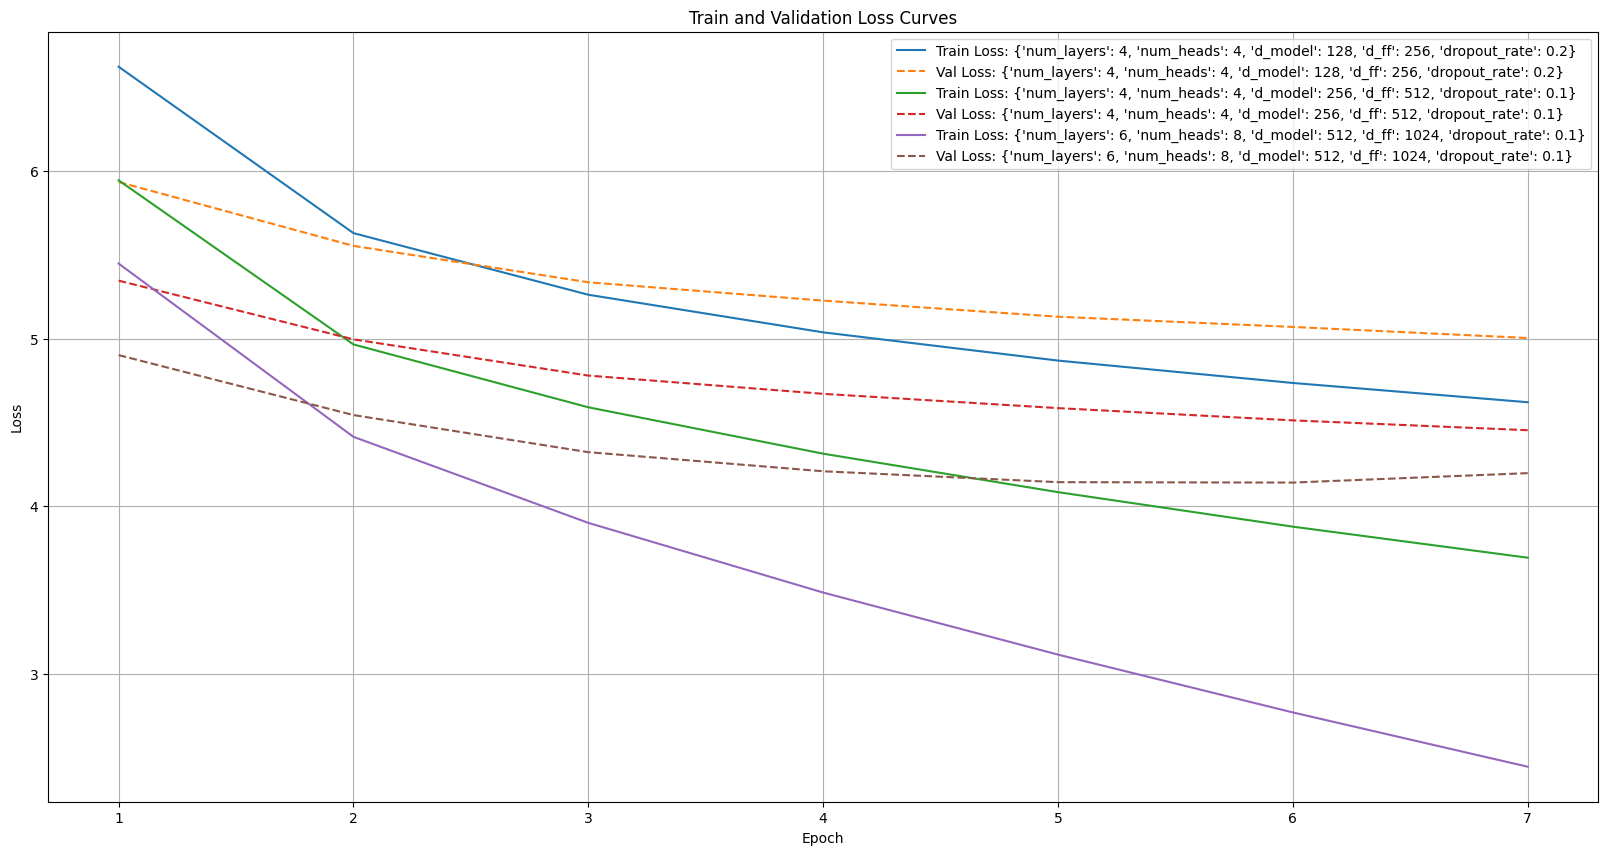

In [63]:
import matplotlib.pyplot as plt

# Plot train and validation loss curves
plt.figure(figsize=(20, 10))
for result in results:
    epochs = list(range(1, len(result['train_losses']) + 1))
    plt.plot(epochs, result['train_losses'], label=f"Train Loss: {result['hyperparams']}")
    plt.plot(epochs, result['val_losses'], label=f"Val Loss: {result['hyperparams']}", linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

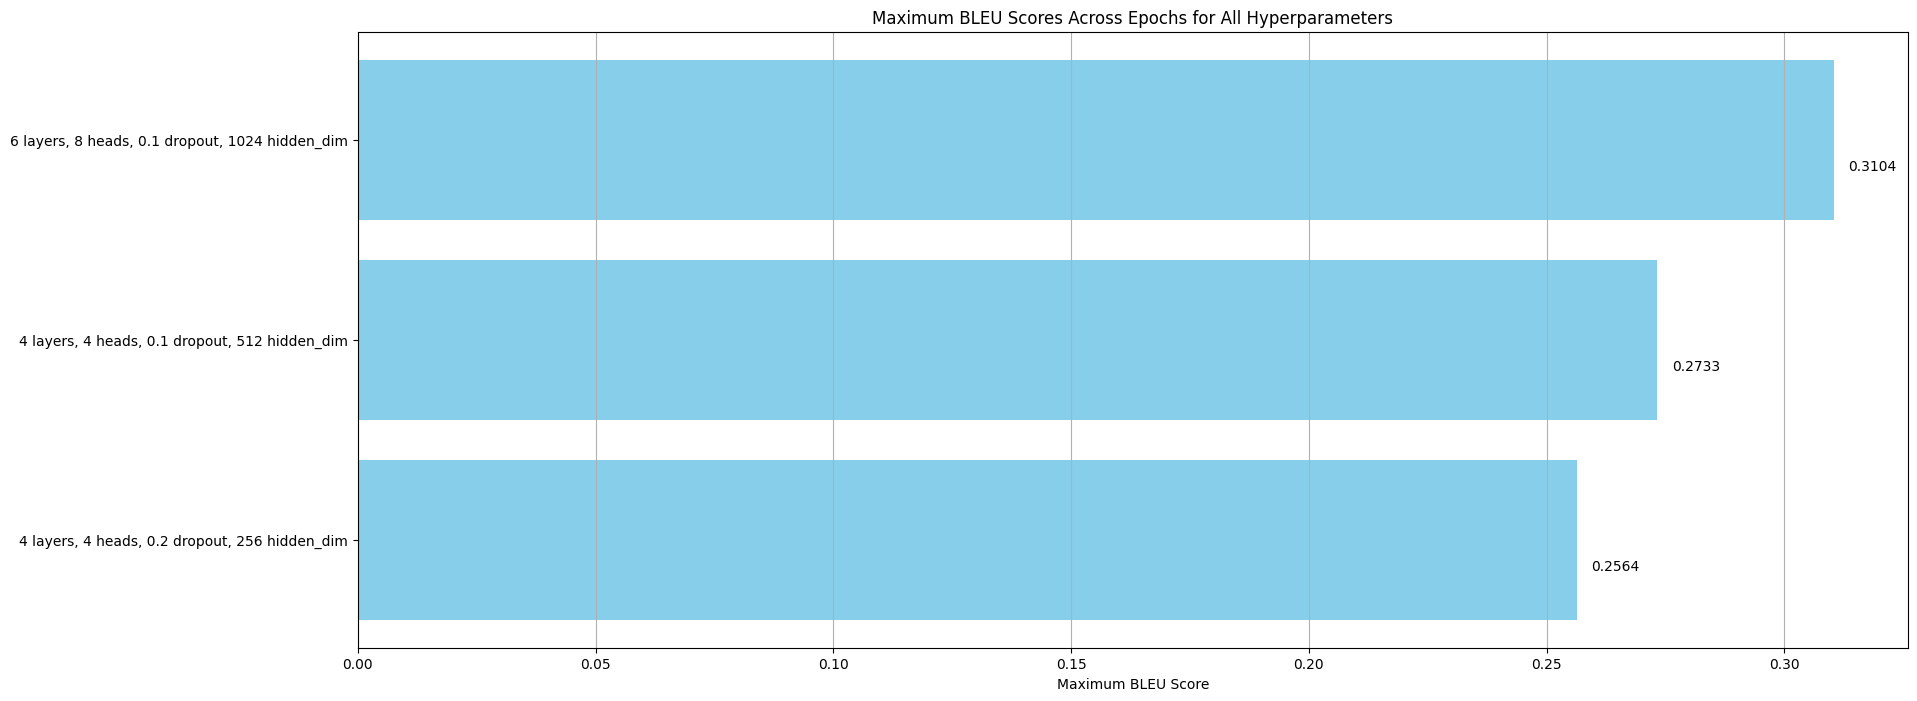

In [62]:
# Plot maximum BLEU scores for each hyperparameter setting
max_bleu = [max(result['bleu_scores']) for result in results]
hyperparams = [f"{res['hyperparams']['num_layers']} layers, {res['hyperparams']['num_heads']} heads, {res['hyperparams']['dropout_rate']} dropout, {res['hyperparams']['d_ff']} hidden_dim" for res in results]
plt.figure(figsize=(20, 8))
bars = plt.barh(hyperparams, max_bleu, color='skyblue')

# Annotate each bar with its corresponding value
for bar, score in zip(bars, max_bleu):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_height()/3, f'{score:.4f}', 
             va='center', fontsize=10)

plt.xlabel('Maximum BLEU Score')
plt.title('Maximum BLEU Scores Across Epochs for All Hyperparameters')
plt.grid(True, axis='x')
plt.show()

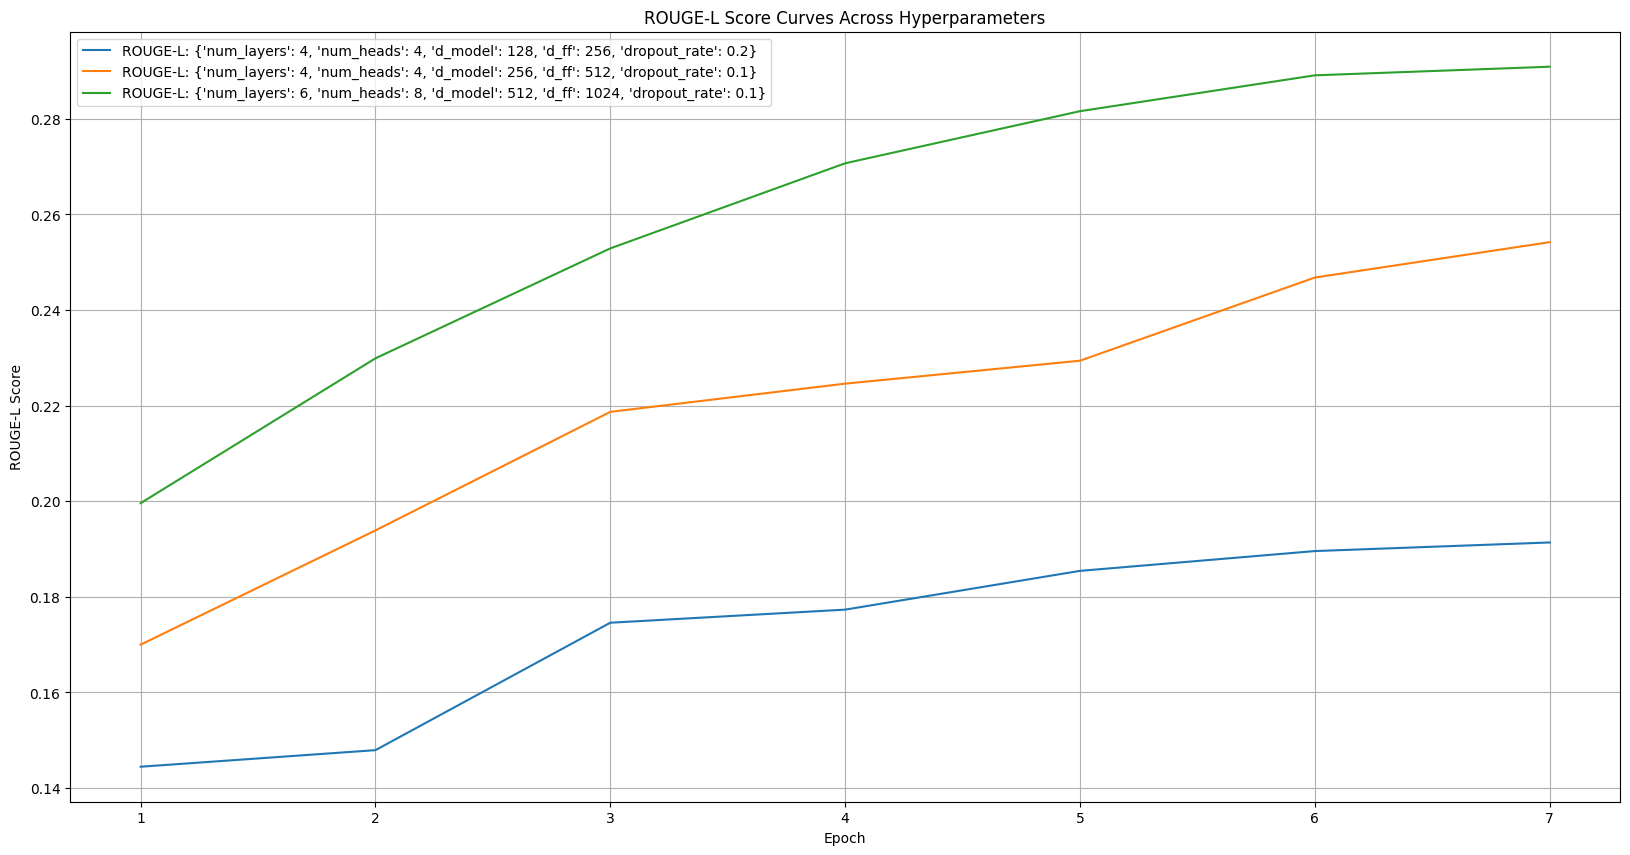

In [45]:
# Plot ROUGE score curves
plt.figure(figsize=(20, 10))
for result in results:
    epochs = list(range(1, len(result['rouge_scores']) + 1))
    plt.plot(epochs, result['rouge_scores'], label=f"ROUGE-L: {result['hyperparams']}")

plt.xlabel('Epoch')
plt.ylabel('ROUGE-L Score')
plt.title('ROUGE-L Score Curves Across Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()


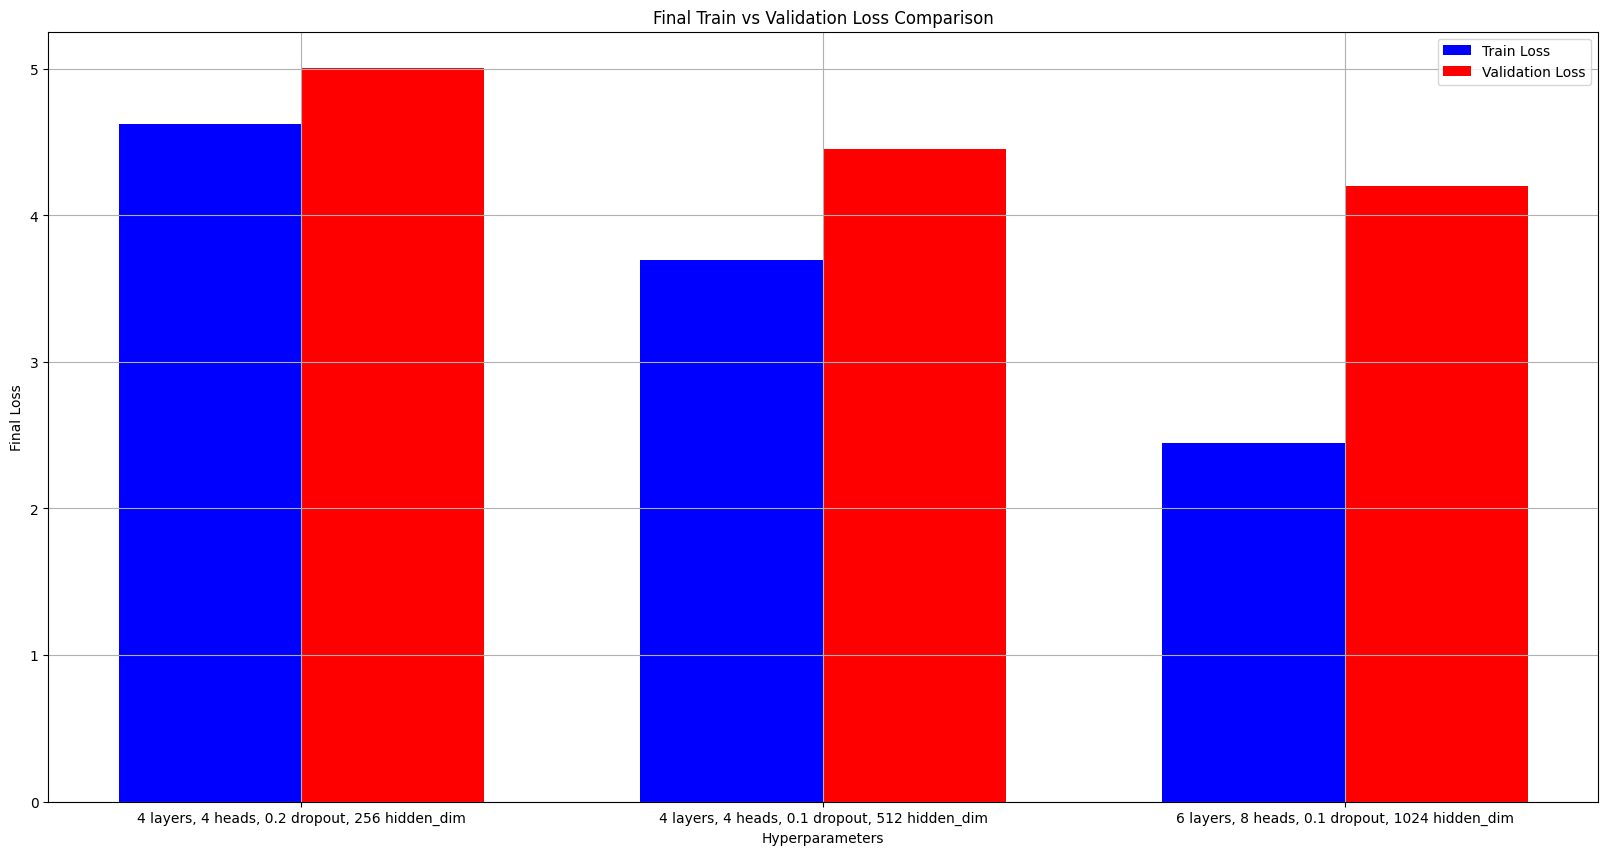

In [53]:
# Plot final train and validation losses for all hyperparameters
final_train_losses = [result['train_losses'][-1] for result in results]
final_val_losses = [result['val_losses'][-1] for result in results]

plt.figure(figsize=(20, 10))
width = 0.35  # Bar width
x = list(range(len(hyperparams)))

plt.bar(x, final_train_losses, width, label='Train Loss', color='blue')
plt.bar([p + width for p in x], final_val_losses, width, label='Validation Loss', color='red')

plt.xlabel('Hyperparameters')
plt.ylabel('Final Loss')
plt.title('Final Train vs Validation Loss Comparison')
plt.xticks([p + width / 2 for p in x], hyperparams)
plt.legend()
plt.grid(True)
plt.show()

---

---

In [23]:
def load_checkpoint(filename="transformer_checkpoint.pth.tar", device=torch.device('cpu')):
    """
    Load the model checkpoint, including model weights, optimizer, and vocabularies.
    
    Args:
        filename (str): Path to the checkpoint file.
        device (torch.device): The device to load the model on (e.g., 'cpu' or 'cuda').
        
    Returns:
        model: The Transformer model loaded with the state_dict.
        optimizer: The optimizer with its state loaded.
        word2idx_en: The English vocabulary mapping.
        word2idx_fr: The French vocabulary mapping.
        idx2word_en: The reverse vocabulary for English.
        idx2word_fr: The reverse vocabulary for French.
    """
    checkpoint = torch.load(filename, map_location=device)
    
    # Load vocabularies
    word2idx_en = checkpoint['src_vocab']
    word2idx_fr = checkpoint['tgt_vocab']
    idx2word_en = checkpoint['idx2word_en']
    idx2word_fr = checkpoint['idx2word_fr']
    
    # Reconstruct the model architecture
    model = Transformer(
        src_vocab_size=len(word2idx_en),
        tgt_vocab_size=len(word2idx_fr),
        src_pad_idx=word2idx_en['<pad>'],
        tgt_pad_idx=word2idx_fr['<pad>'],
        num_layers=checkpoint['num_layers'],
        d_model=checkpoint['d_model'],
        num_heads=checkpoint['num_heads'],
        d_ff=checkpoint['d_ff'],
        dropout_rate=checkpoint['dropout_rate']
    ).to(device)
    
    # Load the model's saved weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, word2idx_en, word2idx_fr, idx2word_en, idx2word_fr

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = "/kaggle/input/model_chkpt_complete/other/default/1/transformer_checkpoint.pth.tar"

print(device)


model, word2idx_en, word2idx_fr, idx2word_en, idx2word_fr = load_checkpoint(path, device)

In [ ]:
print(len(word2idx_en))

In [26]:
max_len_en = 507
max_len_fr = 546

In [27]:
def preprocess_test_data(test_sentences: List[str], word2idx: Dict[str, int], max_len):
    """
    Preprocess test data by adding <sos> and <eos> tokens and padding.
    
    Args:
        test_en_sentences (List[str]): List of raw English test sentences.
        word2idx_en (Dict[str, int]): Source language vocabulary mapping (word2idx).
        max_len_en (int): Maximum sequence length for source language (same as used during training).
    
    Returns:
        List[torch.Tensor]: List of tokenized, padded tensors for test data.
    """
    # Preprocess sentences: lowercase, remove punctuation, etc.
    test_sentences = [preprocess_sentence(s) for s in test_sentences]

    # Add <sos> and <eos> tokens
    test_sentences = add_special_tokens(test_sentences)
    
    # Store original sentence lengths (before padding)
    lengths = [len(s.split()) for s in test_sentences]

    max_len_see = max(lengths) 
    print(f"Max lens see: {max_len_see}")
    
    # Pad sentences to the same max length as training
    test_sentences = pad_sentences(test_sentences, max_len_see)

    # Convert sentences to indices using word2idx mapping
    test_indices = []
    for sentence in test_sentences:
        indices = [word2idx.get(word, word2idx[UNK_TOKEN]) for word in sentence.split()]
        test_indices.append(torch.tensor(indices, dtype=torch.long))

    return test_indices, max_len_see

# Example usage
test_en = load_data("/kaggle/input/translation-task/ted-talks-corpus/test.en")  # Load raw test data
test_en_tensors, max_len_en_test = preprocess_test_data(test_en, word2idx_en, max_len_en)  # Preprocess test data
print("Loaded test english tensors successfully!")

test_fr = load_data("/kaggle/input/translation-task/ted-talks-corpus/test.fr")  # Load raw test data
test_fr_tensors, max_len_fr_test = preprocess_test_data(test_fr, word2idx_fr, max_len_fr)  # Preprocess test data
print("Loaded test french tensors successfully!")

Max lens see: 86
Loaded test english tensors successfully!
Max lens see: 107
Loaded test french tensors successfully!


In [28]:
print(len(test_en_tensors))

print(len(test_fr_tensors))

1305
1305


In [29]:
from torch.utils.data import DataLoader, Dataset

class TranslationTestDataset(Dataset):
    def __init__(self, src_tensors, tgt_tensors):
        """
        Dataset for loading test data.

        Args:
            src_tensors (List[torch.Tensor]): List of preprocessed source (English) tensors.
            tgt_tensors (List[torch.Tensor]): List of preprocessed target (French) tensors.
        """
        self.src_tensors = src_tensors
        self.tgt_tensors = tgt_tensors

    def __len__(self):
        return len(self.src_tensors)

    def __getitem__(self, idx):
        return self.src_tensors[idx], self.tgt_tensors[idx]

# Create the test dataset
test_dataset = TranslationTestDataset(test_en_tensors, test_fr_tensors)

# Create the DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Adjust batch_size as needed

In [30]:
import torch

def load_model_from_state_dict(model_class, filename="scratch_transformer_model.pth", device=torch.device('cpu')):
    """
    Load a model's state dictionary from a file.

    Args:
        model_class (nn.Module): The model class to instantiate.
        filename (str): The path to the saved state dictionary.
        device (torch.device): The device to map the model to.

    Returns:
        model (nn.Module): The model with the loaded state dictionary.
    """
    # Initialize the model architecture
    model = model_class().to(device)
    
    # Load the saved state dictionary
    state_dict = torch.load(filename, map_location=device)
    model.load_state_dict(state_dict)
    
    return model


model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    src_pad_idx=src_pad_idx,
    tgt_pad_idx=tgt_pad_idx,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    dropout_rate=dropout_rate
)

print(device)
model = load_model_from_state_dict(lambda: model, "/kaggle/input/machine-translation/other/default/1/scratch_transformer_model (1).pth", device)

cuda


/tmp/ipykernel_30/225355132.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=device)


In [31]:
model.eval()

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(21590, 512)
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=512, out_features=512, bias=True)
          (W_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ffn): FeedForward(
          (fc1): Linear(in_features=512, out_features=1024, bias=True)
          (fc2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (embedding): E

In [32]:
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_fr[PAD_TOKEN])  # Target padding token

src_pad_idx = word2idx_en[PAD_TOKEN]
tgt_pad_idx = word2idx_fr[PAD_TOKEN]

print(src_pad_idx)
print(tgt_pad_idx)

0
0


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [33]:
def evaluate_model(model, test_dataloader, criterion, device):
    """
    Evaluate the Transformer model on the test dataset.

    Args:
        model (nn.Module): The trained Transformer model.
        test_dataloader (DataLoader): DataLoader for the test dataset.
        criterion (nn.CrossEntropyLoss): Loss function.
        device (torch.device): Device to run the evaluation on.

    Returns:
        float: The average loss over the test dataset.
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Evaluating...")
    
    with torch.no_grad():
        for batch_idx, batch in progress_bar:
            src_batch, tgt_batch = batch
            # Move data to device
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # Forward pass
            outputs = model(src_batch, tgt_batch)

            # Prepare target output (shifted by 1 to exclude <sos>)
            tgt_output = tgt_batch[:, 1:].contiguous().view(-1)  # (batch_size * (tgt_len - 1))

            # Reshape model outputs for loss computation
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * (tgt_len - 1), tgt_vocab_size)

            # Compute loss
            loss = criterion(outputs, tgt_output)

            # Accumulate total loss
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            num_batches += 1
            

    # Calculate average loss
    avg_loss = total_loss / num_batches
    return avg_loss

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loss = evaluate_model(model, test_dataloader, criterion, device)
print(f"Average Test Loss: {test_loss:.4f}")

Evaluating...: 100%|██████████| 1305/1305 [00:18<00:00, 68.97it/s, loss=3.01]    

Average Test Loss: 3.9965


In [34]:
!pip install nltk rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1b2126b7d5eb5119314a1537ef3efa65227829d18694b23e8ed0bb6638ef25a8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [35]:
import torch
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def translate_sentence(model, src_seq, word2idx_fr, idx2word_fr, max_len=50, device='cpu'):
    """
    Generate a translation for a single source sentence.
    
    Args:
        model (nn.Module): The trained Transformer model.
        src_seq (torch.Tensor): The source sequence tensor.
        word2idx_fr (Dict[str, int]): Target language vocabulary mapping.
        idx2word_fr (Dict[int, str]): Target language reverse vocabulary mapping.
        max_len (int): Maximum length of the generated translation.
        device (torch.device): The device to run the model on.
    
    Returns:
        List[str]: The generated translation as a list of tokens.
    """
    model.eval()
    src_seq = src_seq.to(device)
    src_mask = create_padding_mask(src_seq, src_seq, word2idx_fr[PAD_TOKEN])

    with torch.no_grad():
        # Encode the source sentence
        enc_output = model.encoder(src_seq, src_mask)

        # Initialize the target sentence with <sos> token
        tgt_indices = [word2idx_fr[SOS_TOKEN]]

        for _ in range(max_len):
            tgt_input = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            
            tgt_mask = create_combined_mask(tgt_input, word2idx_fr[PAD_TOKEN])
            
            cross_attn_mask = create_padding_mask(tgt_input, src_seq, src_pad_idx)            
            
            # Decode step-by-step
            dec_output = model.decoder(tgt_input, enc_output, tgt_mask, cross_attn_mask)
            logits = model.final_layer(dec_output)
            
            # Get the predicted token (take the token with the highest probability)
            next_token_logits = logits[:, -1, :]  # Last token
            next_token = torch.argmax(next_token_logits, dim=-1).item()
            
            if next_token == word2idx_fr[EOS_TOKEN]:
                break

            tgt_indices.append(next_token)

    # Convert token indices to words
    translation_tokens = [idx2word_fr[idx] for idx in tgt_indices[1:]]  # Skip the <sos> token
    return translation_tokens

In [36]:
from nltk.translate.bleu_score import SmoothingFunction

def compute_bleu(reference, translation):
    """
    Compute BLEU score for a single reference and translation.
    
    Args:
        reference (List[str]): The reference sentence as a list of tokens.
        translation (List[str]): The translated sentence as a list of tokens.
    
    Returns:
        float: BLEU score.
    """
    smoothing_function = SmoothingFunction().method7
    if len(translation) == 1:
        # If translation is a single word, compute BLEU-1
        weights = (1.0,)
    else:
        # Use default weights or adjust as needed
        weights = (0.25, 0.25, 0.25, 0.25)
    return sentence_bleu(
        [reference], 
        translation, 
        smoothing_function=smoothing_function, 
        weights=weights
    )

def compute_rouge(reference, translation):
    """
    Compute ROUGE score for a single reference and translation.
    
    Args:
        reference (List[str]): The reference sentence as a list of tokens.
        translation (List[str]): The translated sentence as a list of tokens.
    
    Returns:
        Dict: ROUGE-L score.
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference), ' '.join(translation))
    return scores['rougeL'].fmeasure

In [37]:
def evaluate_test_data(model, test_dataloader, word2idx_fr, idx2word_fr, device):
    """
    Evaluate the Transformer model on the test dataset.
    
    Args:
        model (nn.Module): The trained Transformer model.
        test_dataloader (DataLoader): DataLoader for the test dataset.
        word2idx_fr (Dict[str, int]): Target language vocabulary.
        idx2word_fr (Dict[int, str]): Target language reverse vocabulary.
        device (torch.device): The device to run the model on.
    
    Returns:
        float, float: Average BLEU and ROUGE scores over the test dataset.
    """
    total_bleu = 0.0
    total_rouge = 0.0
    num_sentences = 0

    # Create files to store individual sentence scores
    with open("testbleu.txt", "w") as f:

        batch_bleu_scores = []
        batch_rouge_scores = []
        
        for src_batch, tgt_batch in tqdm(test_dataloader, desc="Evaluating Test Set"):
            curr_bleu_sc = 0.0
            curr_rouge_sc = 0.0
            for i in range(src_batch.size(0)):
                src_sentence = src_batch[i].unsqueeze(0)  # Get single sentence
                reference = tgt_batch[i].tolist()  # Reference (ground truth)

                translation = translate_sentence(model, src_sentence, word2idx_fr, idx2word_fr, max_len=max_len_fr_test + 1, device=device)

                reference_tokens = [idx2word_fr[idx] for idx in reference if idx != word2idx_fr[PAD_TOKEN] and idx != word2idx_fr[SOS_TOKEN] and idx != word2idx_fr[EOS_TOKEN]]
                
                bleu_score = compute_bleu(reference_tokens, translation)
                rouge_score = compute_rouge(reference_tokens, translation)

                total_bleu += bleu_score
                total_rouge += rouge_score
                curr_bleu_sc += bleu_score
                curr_rouge_sc += rouge_score
                num_sentences += 1

                # write the actual reference sentence and the bleu score to a file in format: sentence \t bleu
                reference_sentence = " ".join(reference_tokens)
                f.write(f"{reference_sentence}\t{bleu_score}\n")

            batch_bleu_scores.append(curr_bleu_sc / src_batch.size(0))
            batch_rouge_scores.append(curr_rouge_sc / src_batch.size(0))
    
    batch_bleu_scores.sort()
    batch_rouge_scores.sort()
    trim = int(0.1 * len(batch_bleu_scores))

    # exclude bottom 10% of the batch scores on both sides
    batch_bleu_scores = batch_bleu_scores[trim:]
    batch_rouge_scores = batch_rouge_scores[trim:]

    avg_bleu_trim = sum(batch_bleu_scores) / len(batch_bleu_scores)
    avg_rouge_trim = sum(batch_rouge_scores) / len(batch_rouge_scores)
    
    # Compute average scores
    avg_bleu = total_bleu / num_sentences
    avg_rouge = total_rouge / num_sentences

    return avg_bleu, avg_rouge, avg_bleu_trim, avg_rouge_trim, batch_bleu_scores, batch_rouge_scores


avg_bleu, avg_rouge, avg_bleu_trim, avg_rouge_trim, batch_bleu_scores, batch_rouge_scores = evaluate_test_data(model, test_dataloader, word2idx_fr, idx2word_fr, device)
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average ROUGE-L Score: {avg_rouge:.4f}")
print(f"Average BLEU Score Trimmed: {avg_bleu_trim:.4f}")
print(f"Average ROUGE-L Score Trimmed: {avg_rouge_trim:.4f}")

Evaluating Test Set: 100%|██████████| 1305/1305 [03:31<00:00,  6.18it/s]

Average BLEU Score: 0.2797
Average ROUGE-L Score: 0.3195
Average BLEU Score Trimmed: 0.2976
Average ROUGE-L Score Trimmed: 0.3448


In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_bleu_vs_sentence_length(bleu_scores_file):
    """
    Plots the average BLEU score as a function of sentence length.

    Args:
        bleu_scores_file (str): Path to the file containing sentences and their BLEU scores.
    
    Returns:
        None
    """
    # Dictionary to store total bleu score and count of sentences by sentence length
    sentence_length_bleu = defaultdict(list)
    
    # Read bleu scores from file
    with open(bleu_scores_file, 'r') as f:
        for line in f:
            sentence, bleu_score = line.split('\t')
            sentence_length = len(sentence.split())
            bleu_score = float(bleu_score.strip())
            sentence_length_bleu[sentence_length].append(bleu_score)
    
    # Calculate average BLEU scores for each sentence length
    lengths = []
    avg_bleu_scores = []
    for length, bleu_list in sorted(sentence_length_bleu.items()):
        avg_bleu = sum(bleu_list) / len(bleu_list)
        lengths.append(length)
        avg_bleu_scores.append(avg_bleu)

    # Plotting the curve
    plt.figure(figsize=(8, 5))
    plt.plot(lengths, avg_bleu_scores, marker='o', linestyle='-', color='blue')
    plt.title('Average BLEU Score vs Sentence Length')
    plt.xlabel('Sentence Length')
    plt.ylabel('Average BLEU Score')
    plt.grid(True)
    plt.show()

# Example usage
bleu_scores_file = 'testbleu.txt'
plot_bleu_vs_sentence_length(bleu_scores_file)